In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imread, imshow
from skimage.filters import prewitt_h,prewitt_v
import imutils
from tqdm import tqdm
from PIL import Image
from scipy.stats import kurtosis
from skimage import io, filters, measure
import warnings
warnings.filterwarnings("ignore")
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import skew

In [2]:
# Training
data = 'E:/Brain tumor ml/dataset/Training'
No_tumor = 'E:/Brain tumor ml/dataset/Training/notumor'
glioma_tumor = 'E:/Brain tumor ml/dataset/Training/glioma'
meningioma_tumor = 'E:/Brain tumor ml/dataset/Training/meningioma'
pituitary_tumor = 'E:/Brain tumor ml/dataset/Training/pituitary'


In [4]:
dirlist=[No_tumor, glioma_tumor, meningioma_tumor, pituitary_tumor]
classes=['No', 'glioma', 'meningioma', 'pituitary']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths:', len(filepaths), '   labels:', len(labels))

# save the DataFrame as a CSV file
filepath_df = pd.DataFrame({'filepath':filepaths, 'Label':labels})
filepath_df
filepath_df.to_csv('training_paths.csv', index=False)

filepaths: 5712    labels: 5712


In [5]:
paths = pd.read_csv('training_paths.csv')
paths.head()

,filepath,Label
0,E:/Brain tumor ml/dataset/Training/notumor\Tr-...,No
1,E:/Brain tumor ml/dataset/Training/notumor\Tr-...,No
2,E:/Brain tumor ml/dataset/Training/notumor\Tr-...,No
3,E:/Brain tumor ml/dataset/Training/notumor\Tr-...,No
4,E:/Brain tumor ml/dataset/Training/notumor\Tr-...,No


In [6]:
paths['Label'].value_counts()

Label
No            1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64

In [7]:
def crop_img(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    return new_img

In [8]:
def image_features(path):
    # image_feature_data = [mean, std, entropy, rms, kurtios, hmi]
    image_feature_data = []
    ########################### First order statical features #############################################
    img = cv2.imread(path)
    # Mean of image
    mean_of_img = np.mean(img)
    image_feature_data.append(mean_of_img)
    
    # Standard deviation of image
    std_of_img = np.std(img)
    image_feature_data.append(std_of_img)
    
    # Vaiance of image
    # Convert the image to a NumPy array
    image_array = np.array(img)
    # Compute the variance of the pixel intensities
    variance = np.var(image_array)
    image_feature_data.append(variance)
    
    # Skewness of image
    # Flatten the array to a 1D array of pixel intensities
    pixel_values = image_array.flatten()
    # Compute the skewness of the pixel intensities
    skewness = skew(pixel_values)
    image_feature_data.append(skewness)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ########################### Enotropy #############################################
    # Compute the histogram of the image
    hist, _ = np.histogram(gray, bins=256, range=(0, 255))
    # Normalize the histogram
    hist = hist / np.sum(hist)
    # Compute the entropy of the image
    entropy = -np.sum(hist * np.log2(hist + 1e-9))
    image_feature_data.append(entropy)
    
    ########################### RMS #############################################
    # Compute the RMS of the image
    rms = np.sqrt(np.mean(np.square(img)))
    image_feature_data.append(rms)
    
    ########################### kurtosis #############################################
    # Calculate the kurtosis of the image
    k = kurtosis(img.flatten())
    image_feature_data.append(k)
    ########################### HMI #############################################
    # Calculate the image moments of the grayscale image
    moments = cv2.moments(gray)
    # Calculate the centroid of the grayscale image
    cx = int(moments['m10'] / moments['m00'])
    cy = int(moments['m01'] / moments['m00'])
    # Define the radius of the circular mask
    radius = int(min(gray.shape) * 0.4)
    # Create the circular mask
    mask = np.zeros_like(gray)
    cv2.circle(mask, (cx, cy), radius, 255, -1)
    # Apply the mask to the grayscale image
    masked_gray = cv2.bitwise_and(gray, gray, mask=mask)
    # Calculate the Hu moments of the masked grayscale image
    hu_moments = cv2.HuMoments(cv2.moments(masked_gray)).flatten()
    # Normalize the Hu moments
    hu_moments_normalized = -np.sign(hu_moments) * np.log10(np.abs(hu_moments))
    # Extract the first four Hu moment invariants
    # (HU1) brightness or intensity of the image
    # (HU2) is related to the symmetry of the image around its vertical axis
    # (HU3) is related to the symmetry of the image around its horizontal axis.
    # (HU4) is related to the skewness of the image, or the degree to which it is asymmetrical.
    hu_invariants = hu_moments_normalized[:4]
    image_feature_data.append(hu_moments_normalized[0])
    image_feature_data.append(hu_moments_normalized[1])
    image_feature_data.append(hu_moments_normalized[2])
    image_feature_data.append(hu_moments_normalized[3])
    return image_feature_data
 
    
"""
Finds GLCM features extracted from the main image
"""
def get_feature(img):
    fet = []
    image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    distances = [1]  # Specify the pixel distances for the GLCM
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Specify the angles for the GLCM
    glcm = graycomatrix(image_gray, distances, angles, levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')
    for i in range(len(contrast[0])):
        fet.append(contrast[0][i])
    dissimilarity = graycoprops(glcm, 'dissimilarity')
    for x in range(len(dissimilarity[0])):
        fet.append(dissimilarity[0][x])
    homogeneity = graycoprops(glcm, 'homogeneity')
    for y in range(len(homogeneity[0])):
        fet.append(homogeneity [0][y])
    energy = graycoprops(glcm, 'energy')
    for z in range(len(energy[0])):
        fet.append(energy[0][z])
    correlation = graycoprops(glcm, 'correlation')
    for v in range(len(correlation[0])):
        fet.append(correlation[0][v])
    return fet

Extract Tumor features


In [9]:
# the mean of all tumor contours   
def image_process_tumor_extraction(img):     
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     print(gray_img.shape)
    blur_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
    ret, thres_img = cv2.threshold(blur_img,100,255,cv2.THRESH_BINARY)
#     titles = ['Original Image', 'Gray','Blured', 'Threshold']
#     images_phases = [img, gray_img,blur_img, thres_img ]
#     for i in range(len(images_phases)):
#         plt.subplot(2,2,i+1),plt.imshow(images_phases[i],'gray')
#         plt.title(titles[i])
#         plt.xticks([]),plt.yticks([])
#     plt.show()
    contours, hierarchy = cv2.findContours(thres_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    full_contoured_img = cv2.drawContours(img, contours, -1, (0,255,0), 3)
#     plt.imshow(full_contoured_img)
#     plt.show()
    
    # Select the contour(s) that correspond to the tumor
    tumor_contours = []
    tumor_contour_areas = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 1000 and area < 50000:
            tumor_contour_areas.append(area)
            tumor_contours.append(contour)
       
    area_of_tumor_contours = []
    perimeter_of_tumor_contours = []
    circulatory_of_tumor_contours = []
    convexity_of_tumor_contours = []
#     fractal_dimension_tumor_contours = []
    solidity_tumor_contours = []
    diameter_tumor_contours = []
    major_axis = []
    minor_axis = []
    eccentricity_tumor_contours = []
    # for extraction of the mean of features of the tumor_contours
    features_tumor_array = [area_of_tumor_contours, perimeter_of_tumor_contours, circulatory_of_tumor_contours, convexity_of_tumor_contours, solidity_tumor_contours, diameter_tumor_contours, major_axis, minor_axis]
#     print(len(features_tumor_array))
    if len(tumor_contours)>0:
        for cnt in tumor_contours:
            ################################ Area Feature  #################################
            area = cv2.contourArea(cnt)
            # print('Area - {}'.format(area))
            area_of_tumor_contours.append(area)
    
            ############################### perimeter Feature ##############################
            perimeter = cv2.arcLength(cnt, True)
            # print('Perimeter - {}'.format(perimeter))
            perimeter_of_tumor_contours.append(perimeter)
    
            ############################### Circle Feature ##############################
            circularity = (4 * np.pi * area) / (perimeter ** 2)
            circulatory_of_tumor_contours.append(circularity)

            ############################### Convexity Feature ##############################
            convex_hull = cv2.convexHull(cnt)
            convexity = cv2.contourArea(convex_hull)
            convexity_of_tumor_contours.append(convexity)
            
            ############################### solidity Feature ##############################
            if convexity == 0 :
                solidity = 0
            else:
                solidity = float(area)/convexity
            solidity_tumor_contours.append(solidity)

            ############################### Diameter Feature ##############################
            equi_diameter = np.sqrt(4*area/np.pi)
            diameter_tumor_contours.append(equi_diameter)

            ############################### Axis Feature ##############################
            try:
                (x2,y2), (MA,ma), angle = cv2.fitEllipse(cnt)
            except:
                MA = 0
                ma = 0
            major_axis.append(MA)
            minor_axis.append(ma)
    
    features_data = [] 
    if(len(contours) > 0):
        for i in features_tumor_array:
            mean_feature = np.mean(i)
            features_data.append(mean_feature)
        return features_data

    else:
        print('No Tumor Found')
        for i in range(len(features_tumor_array)):
            features_data.append(0)
        return features_data

Create Features DataFrame

In [10]:
frames = ['Mean', 'std', 'Variance', 'Skewness', 'Entropy', 'RMS', 'Kurtios', 'HMI1', 'HMI2', 'HMI3', 'HMI4','Area','Perimeter', 'Circle','Convex Area','Solidity','Equivalent Diameter','Major Axis','Minor Axis',\
                             'contrast1','contrast2','contrast3','contrast4','dissimilarity1','dissimilarity2','dissimilarity3','dissimilarity4','homogeneity1','homogeneity2','homogeneity3','homogeneity4',\
                             'energy1','energy2','energy3','energy4','correlation1','correlation2','correlation3','correlation4','Class']
data = pd.DataFrame(columns=frames)
for i in range(len(paths['filepath'])):
    if paths['Label'][i] == 'No':
        img_path = paths['filepath'][i]
        d = image_features(img_path)
        img = crop_img(img_path)
        tumor_features = image_process_tumor_extraction(img)
        d.extend(tumor_features)
        glcm_features = get_feature(img)
        d.extend(glcm_features)
        d.append(0)
        new_data = pd.DataFrame([d], columns=frames)
        data = pd.concat([data, new_data], ignore_index=True)                                                                                                                                       
    elif paths['Label'][i] == 'pituitary':
        img_path = paths['filepath'][i]
        d = image_features(img_path)
        img = crop_img(img_path)
        tumor_features = image_process_tumor_extraction(img)
        d.extend(tumor_features)
        glcm_features = get_feature(img)
        d.extend(glcm_features)
        d.append(1)
        new_data = pd.DataFrame([d], columns=frames)
        data = pd.concat([data, new_data], ignore_index=True)             
    elif paths['Label'][i] == 'meningioma':
        img_path = paths['filepath'][i]
        d = image_features(img_path)
        img = crop_img(img_path)
        tumor_features = image_process_tumor_extraction(img)
        d.extend(tumor_features)
        glcm_features = get_feature(img)
        d.extend(glcm_features)
        d.append(2)
        new_data = pd.DataFrame([d], columns=frames)
        data = pd.concat([data, new_data], ignore_index=True)      
    else:
        img_path = paths['filepath'][i]
        d = image_features(img_path)
        img = crop_img(img_path)
        tumor_features = image_process_tumor_extraction(img)
        d.extend(tumor_features)
        glcm_features = get_feature(img)
        d.extend(glcm_features)
        d.append(3)
        new_data = pd.DataFrame([d], columns=frames)
        data = pd.concat([data, new_data], ignore_index=True)
data


No Tumor Found
No Tumor Found


,Mean,std,Variance,Skewness,Entropy,RMS,Kurtios,HMI1,HMI2,HMI3,...,homogeneity4,energy1,energy2,energy3,energy4,correlation1,correlation2,correlation3,correlation4,Class
0,69.693600,60.988672,3719.618054,0.753146,6.614287,9.041661,0.415330,2.785595,10.037521,10.662000,...,0.405790,0.306356,0.299436,0.313603,0.299894,0.921058,0.902715,0.940892,0.902733,0
1,42.088384,50.356683,2535.795494,2.049944,6.553086,8.875129,5.073736,2.617668,7.231273,9.914340,...,0.306209,0.212378,0.206820,0.214469,0.205028,0.895421,0.864810,0.906165,0.862465,0
2,55.212544,46.056565,2121.207208,0.370450,5.375762,9.302612,-0.628678,2.752905,8.030957,11.070417,...,0.513325,0.177499,0.172328,0.180325,0.171641,0.969317,0.959636,0.974818,0.958198,0
3,76.037273,79.565990,6330.746828,0.585233,5.781641,7.635726,-0.877843,2.904895,7.803627,12.448359,...,0.432991,0.230150,0.221221,0.232777,0.221043,0.969677,0.958555,0.973180,0.957760,0
4,49.957904,48.439813,2346.415459,1.237070,5.764681,10.755480,1.467716,2.720641,7.122902,10.259218,...,0.466591,0.179320,0.170887,0.181765,0.170025,0.959890,0.947522,0.966923,0.945591,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5707,55.537216,41.476325,1720.285572,0.500769,6.681584,9.934108,-0.125073,2.678192,8.030136,10.921777,...,0.354122,0.149783,0.145493,0.154335,0.144780,0.932639,0.914916,0.949625,0.912128,1
5708,58.451622,42.845989,1835.778749,0.488612,6.740698,10.103457,-0.062257,2.700193,8.071390,10.813083,...,0.334873,0.136611,0.132942,0.141475,0.131985,0.936218,0.921140,0.955264,0.920016,1
5709,45.893677,33.173744,1100.497301,0.478187,6.370771,9.474798,0.096858,2.585893,7.683718,10.163987,...,0.321362,0.081568,0.077379,0.082941,0.076869,0.933455,0.915585,0.950032,0.910542,1
5710,41.703392,36.594254,1339.139410,1.058489,6.356158,9.738114,1.184672,2.608306,8.878155,11.275747,...,0.312610,0.100671,0.096011,0.102649,0.095976,0.947402,0.926110,0.953305,0.926715,1


In [11]:
data.columns

Index(['Mean', 'std', 'Variance', 'Skewness', 'Entropy', 'RMS', 'Kurtios',
       'HMI1', 'HMI2', 'HMI3', 'HMI4', 'Area', 'Perimeter', 'Circle',
       'Convex Area', 'Solidity', 'Equivalent Diameter', 'Major Axis',
       'Minor Axis', 'contrast1', 'contrast2', 'contrast3', 'contrast4',
       'dissimilarity1', 'dissimilarity2', 'dissimilarity3', 'dissimilarity4',
       'homogeneity1', 'homogeneity2', 'homogeneity3', 'homogeneity4',
       'energy1', 'energy2', 'energy3', 'energy4', 'correlation1',
       'correlation2', 'correlation3', 'correlation4', 'Class'],
      dtype='object')

In [12]:
data = data.drop(data.index[0])

In [13]:
data.to_csv('training_dataset.csv', index=False) 

In [14]:
data.shape

(5711, 40)

Processing Images & Feature extraction

In [15]:
"""
Finds the extreme points on the image and crops the rectangular out of them
"""
def crop_img(path):
    img = cv2.imread(path)
#     plt.imshow(img)
#     plt.show()
#     print(img.shape)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     print(gray.shape)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 55, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    plt.imshow(new_img)
    plt.title("croped Image")
    plt.show()
    return new_img


"""
1. Finds the contours of the image
2. then extract the tumor contours
3. then extract the mean of area, perimeter, minor ans major axis of contour
"""
# the mean of all tumor contours   
def image_process_tumor_extraction(img): 
    dim=(500,590)
    img = cv2.resize(img, dim)
    img_tumor = img.copy()
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     print(gray_img.shape)
    blur_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
    
    ret, thres_img = cv2.threshold(blur_img,100,255,cv2.THRESH_BINARY)
    
    titles = ['Original Image', 'Gray Scale','Blured Image', \
              'Threshold Image']
    images_phases = [img, gray_img,blur_img, thres_img]
    for i in range(len(images_phases)):
        plt.subplot(2,2,i+1),plt.imshow(images_phases[i],'gray')
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])
    plt.show()
    
    contours, hierarchy = cv2.findContours(thres_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    full_contoured_img = cv2.drawContours(img, contours, -1, (0,255,0), 3)

    
    # Select the contour(s) that correspond to the tumor
    tumor_contours = []
    tumor_contour_areas = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 1000 and area < 50000:
            tumor_contour_areas.append(area)
            tumor_contours.append(contour)
    tumor_contoured_img = cv2.drawContours(img_tumor, tumor_contours, -1, (255,255,0), 3)  
    
    titles_contour = ['Full Contour Image', 'Tumor Image']
    contour_images = [full_contoured_img, tumor_contoured_img ]
    for i in range(len(contour_images)):
        plt.subplot(1,2,i+1),plt.imshow(contour_images[i],'gray')
        plt.title(titles_contour[i])
        plt.xticks([]),plt.yticks([])
    plt.show()

In [16]:
file1 = 'E:/Brain tumor ml/dataset/Training/glioma/Tr-gl_0020.jpg'

# manual cropped
file = 'E:/Brain tumor ml/processed images/1.PNG'
crop_file = 'E:/Brain tumor ml/processed images/2.PNG'

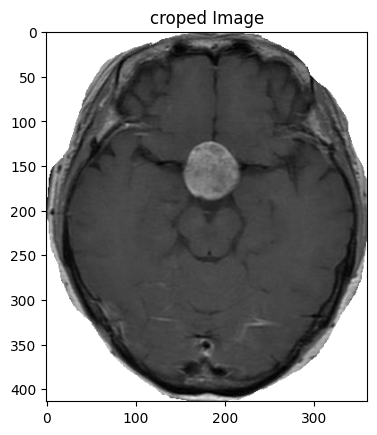

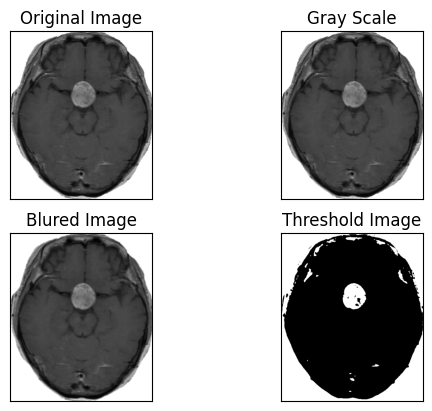

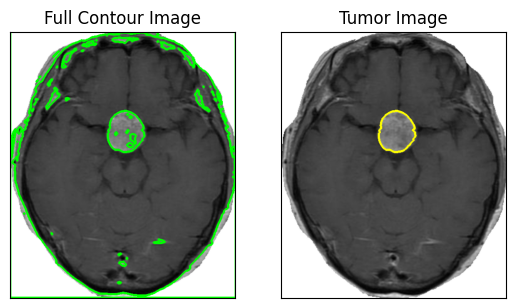

In [17]:
# glioma Tumor
img = crop_img(file)
image_process_tumor_extraction(img)

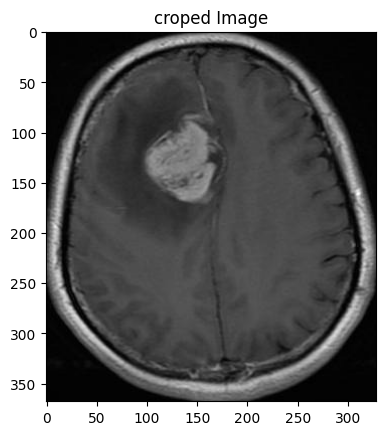

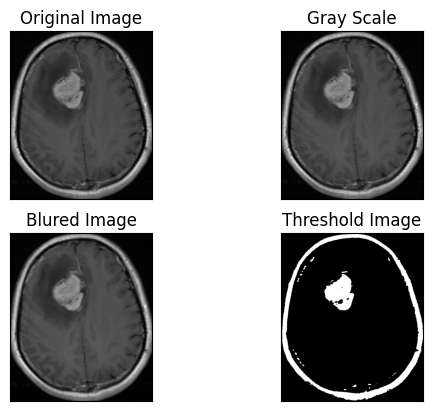

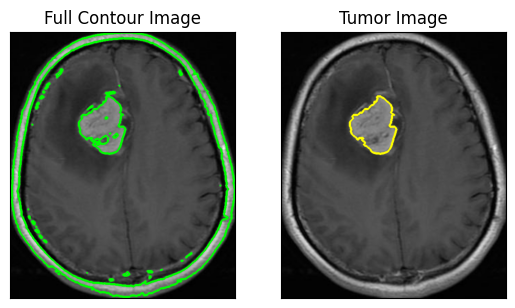

In [18]:
# meningioma Tumor
file2 = 'E:/Brain tumor ml/dataset/Training/meningioma/Tr-me_0016.jpg'

img = crop_img(file2)
image_process_tumor_extraction(img)

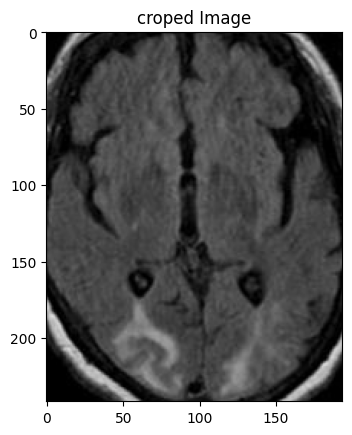

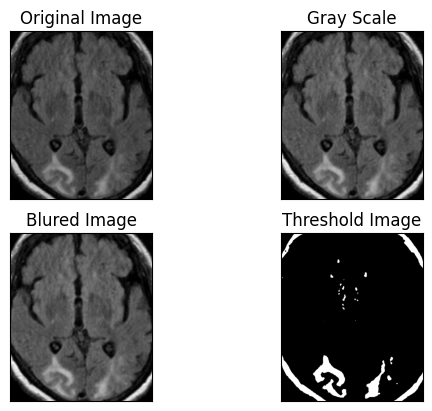

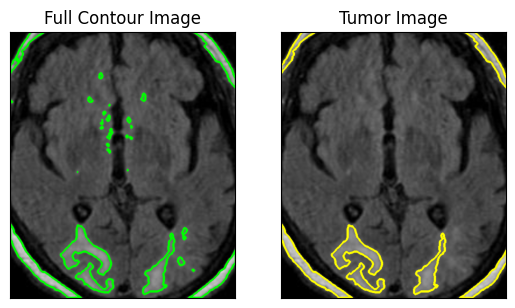

In [19]:
# No Tumor
file3 = 'E:/Brain tumor ml/dataset/Training/notumor/Tr-no_0043.jpg'
img = crop_img(file3)
image_process_tumor_extraction(img)

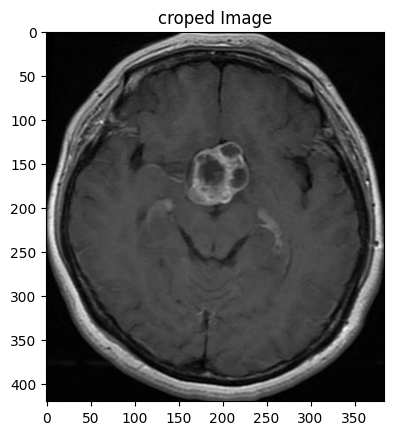

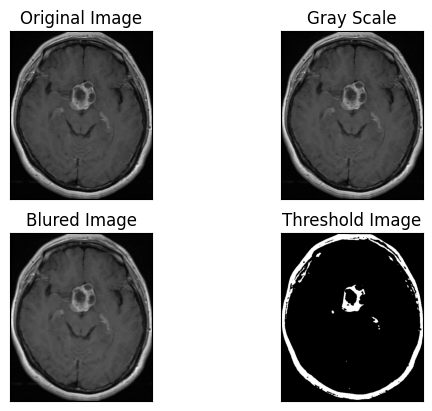

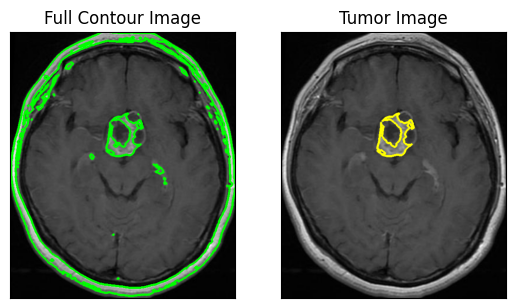

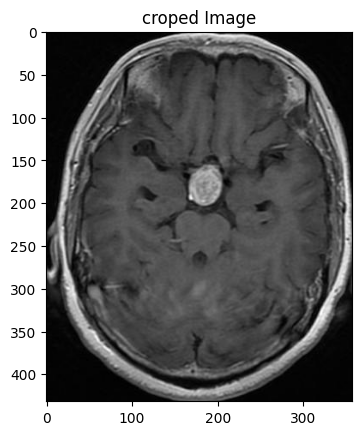

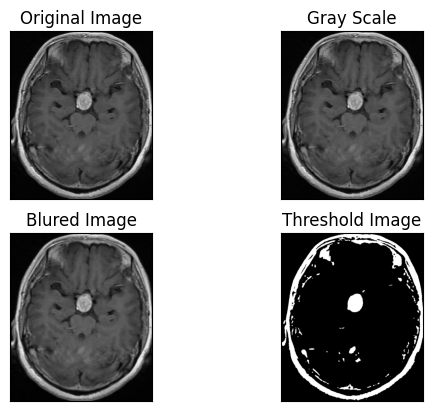

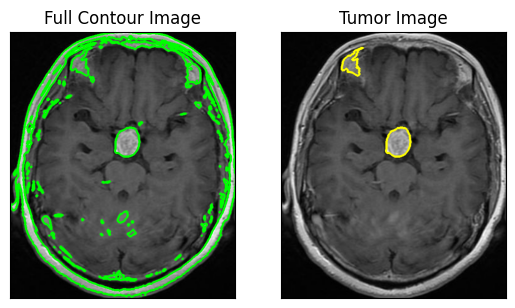

In [20]:
# pituitary Tumor
file4 = 'E:/Brain tumor ml/dataset/Training/pituitary/Tr-pi_0654.jpg'

img = crop_img(file4)
image_process_tumor_extraction(img)

file42 = 'E:/Brain tumor ml/dataset/Training/pituitary/Tr-pi_1022.jpg'
img = crop_img(file42)
image_process_tumor_extraction(img)